In [10]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def load_pickle_images(image_path, label_path, target_size=(100,100)):
    with open(image_path, "rb") as f:
        X = pickle.load(f)
    with open(label_path, "rb") as f:
        y = pickle.load(f)

    X_arr = []
    for img in X:
        img_arr = np.array(img)

        # Resize
        img_arr = cv2.resize(img_arr, target_size)

        # ✅ Convert to GRAY always (so training & prediction are same)
        if len(img_arr.shape) == 3:
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)

        X_arr.append(img_arr)

    X_arr = np.array(X_arr, dtype=np.float32)

    # Normalize and add channel for CNN
    X_arr = X_arr.reshape(-1, target_size[0], target_size[1], 1) / 255.0

    return X_arr, np.array(y)


X, y = load_pickle_images("/content/drive/MyDrive/Colab Notebooks/images.p", "/content/drive/MyDrive/Colab Notebooks/labels.p")
print("✅ Data loaded:", X.shape, y.shape)

✅ Data loaded: (29745, 100, 100, 1) (29745,)


In [11]:
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int)

print("Classes:", le.classes_)
print("Encoded shape:", y_cat.shape)

# Save encoder
with open("labels_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


Classes: ['Apple___Black_rot' 'Apple___Cedar_apple_rust' 'Apple___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'brinjal_healthy'
 'brinjal_little_leaf' 'paddy_Bacterialblight' 'paddy_Brownspot'
 'paddy_Leafsmut']
Encoded shape: (29745, 23)


In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int)

print("Classes:", le.classes_)
print("Encoded shape:", y_cat.shape)

Classes: ['Apple___Black_rot' 'Apple___Cedar_apple_rust' 'Apple___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'brinjal_healthy'
 'brinjal_little_leaf' 'paddy_Bacterialblight' 'paddy_Brownspot'
 'paddy_Leafsmut']
Encoded shape: (29745, 23)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.15, random_state=42, stratify=y_cat
)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (100, 100, 1)   # since you converted to grayscale
num_classes = y_cat.shape[1]  # number of unique diseases

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,734,167 (6.62 MB)

 Trainable params: 1,734,167 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss', min_lr=1e-6)
]

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
     callbacks=callbacks
)


Epoch 1/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.3123 - loss: 2.2682 - val_accuracy: 0.6710 - val_loss: 1.0548 - learning_rate: 0.0010
Epoch 2/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6144 - loss: 1.1758 - val_accuracy: 0.7181 - val_loss: 0.8261 - learning_rate: 0.0010
Epoch 3/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6944 - loss: 0.9090 - val_accuracy: 0.7662 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 4/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7387 - loss: 0.7598 - val_accuracy: 0.8023 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 5/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7782 - loss: 0.6414 - val_accuracy: 0.8200 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 6/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7965 - loss: 0.5773 - val_accuracy: 0.8297 - val_loss: 0.4914 - learning_rate: 0.0010
Epoch 7/20
791/791 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8281 - lo

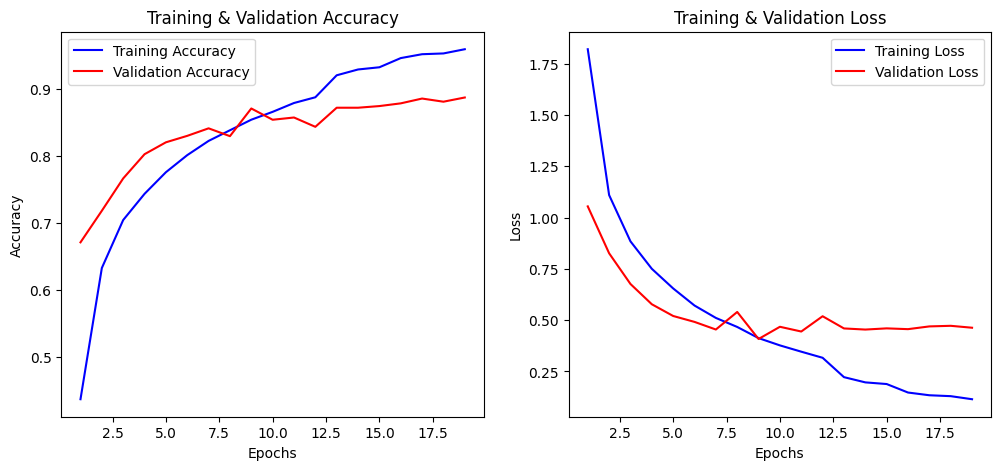

In [19]:
import matplotlib.pyplot as plt

# Assuming you stored history from model.fit() in `history`
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

# Accuracy plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
# Save entire model
model.save("plant_disease_cnn_model_final.h5")
print("✅ Model and label encoder saved successfully!")


✅ Model and label encoder saved successfully!


In [26]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)

# Load trained model
model = load_model("plant_disease_cnn_model_final.h5")

# Load LabelEncoder
with open("labels_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Image size used in training
IMG_SIZE = 100

# Read image
img = cv2.imread(image_path)

# Convert to grayscale if your model was trained in grayscale
# (⚠️ Change this depending on your training)
use_grayscale = True

if use_grayscale:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)  # batch, h, w, channel
else:
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)

# Normalize
img = img / 255.0

# Predict
pred_prob = model.predict(img)
pred_class = np.argmax(pred_prob)
pred_label = le.classes_[pred_class]
confidence = pred_prob[0][pred_class] * 100

print(f"✅ Predicted crop & disease: {pred_label} ({confidence:.2f}% confidence)")


Saving BLAST1_008.jpg to BLAST1_008.jpg
Uploaded: BLAST1_008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
✅ Predicted crop & disease: paddy_Leafsmut (99.70% confidence)
